In [324]:
## IMPORT NECESSARY LIBRARIES

import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import optimize
import pandas as pd

In [345]:
## SAVE FUNCTIONS WE WILL USE

def cleanCSV(filename):
    # Read the CSV file into a Pandas dataframe
    dataFrame = pd.read_csv(filename)

    # Replace slashes with _ in the header (cleaning the data)
    dataFrame.columns = [column.replace('/','_') for column in dataFrame.columns]

    return dataFrame

def prepareData(confirmed, deaths, newcases, hospitalizations, state):
    # Find data from the specified country
    confirmed = confirmed.query('State == @state')
    deaths = deaths.query('State == @state')
    newcases = newcases.query('State == @state')
    hospitalizations = hospitalizations.query('State == @state')

    # Drop columns that we don't need (for comparison with SIR models)
    confirmed = confirmed.drop(['State'], axis=1)
    deaths = deaths.drop(['State'], axis=1)
    newcases = newcases.drop(['State'], axis=1)
    hospitalizations = hospitalizations.drop(['State'], axis=1)
    # we need to know when hospitalization data starts/ends

    # Convert these dataframes to NumPy
    confirmed = confirmed.to_numpy()[0]
    deaths = deaths.to_numpy()[0]
    newcases = newcases.to_numpy()[0]
    hospitalizations = hospitalizations.to_numpy()[0]

    # Read the CSV file for populations
    populations = pd.read_csv('StatePopulations.csv')

    # Drop columns we don't need
    # populations = populations.drop(['State'], axis=1)

    # Query the populations for the country we chose
    populations = populations.query('State == @state')

    # Convert dataframe to NumPy and choose the value in column 1 (population)
    statePopulation = populations.to_numpy()[0][1]

    # Prepare infectious group (Raghav's method)
    infected = np.zeros(93)
    for i in range(0,93):
        # For the ith element of infected, sum the number of cases from day i-9 to day i, but
        # if i-9 < 0, we don't want to take negative inputs to newcases, so we used max(0,i-9) so that,
        # if i-9 is negative, we will start adding only at the beginning of the newcases vector.
        infected[i] = np.sum(newcases[max(0,i-9):i+1])
    infected = np.transpose(infected)

    D = deaths
    H = hospitalizations
    I = infected
    S = statePopulation - confirmed
    R = statePopulation - S - I - H - D

    #firstCase = np.nonzero(I)[0][0] + 10

    #S = S[firstCase:]
    #I = I[firstCase:]
    #R = R[firstCase:]
    #H = H[firstCase:]
    #D = D[firstCase:]

    data = np.vstack((S, I, R, H, D))
    data = np.array(list(data[:,:]), dtype=np.float64)

    return data

# Simulate the SIRHD (SIR + Hospitalizations + Deaths) model
def sirhdBasic(S0, I0, R0, H0, D0, alpha, beta, w, x, y, z, n):
    # Make an empty 3 by 101 matrix that will be the predicted number of people in each group
    SIRHD = np.zeros((5,n+1))
    totalHospitalized = H0

    # fill in the initial data
    SIRHD[:,0] = np.array([S0, I0, R0, H0, D0])

    for i in range(n):
        SIRHD[:,i+1] = SIRHD[:,i] + np.array([-beta*SIRHD[0,i]*SIRHD[1,i],
                                              beta*SIRHD[0,i]*SIRHD[1,i] - (alpha + x + y)*SIRHD[1,i],
                                              alpha*SIRHD[1,i] + z*SIRHD[3,i],
                                              x*SIRHD[1,i] - (z + w)*SIRHD[3,i],
                                              (y + w)*SIRHD[3,i]])

        totalHospitalized += x*SIRHD[1,i]

    return SIRHD, totalHospitalized

# Simulate the advanced SIRHD (SIR + Hospitalizations + Deaths) model (sigmoid hospitalization rate)
# input x1 = initial hospitalization rate
# input x2 = final hospitalization rate
# input xcenter = center of the switch from x1 to x2
# input xrate = how quickly the transition occurs
def sirhdAdvancedH(S0, I0, R0, H0, D0, alpha, beta, w, x1, x2, xcenter, xrate, y, z, n):
    # Make an empty 3 by 101 matrix that will be the predicted number of people in each group
    SIRHD = np.zeros((5,n+1))
    totalHospitalized = H0

    # fill in the initial data
    SIRHD[:,0] = np.array([S0, I0, R0, H0, D0])

    for i in range(n):
        x = (x2 - x1)*sigmoid(xrate*(i - xcenter)) + x1

        SIRHD[:,i+1] = SIRHD[:,i] + np.array([-beta*SIRHD[0,i]*SIRHD[1,i],
                                              beta*SIRHD[0,i]*SIRHD[1,i] - (alpha + x + y)*SIRHD[1,i],
                                              alpha*SIRHD[1,i] + z*SIRHD[3,i],
                                              x*SIRHD[1,i] - (z + w)*SIRHD[3,i],
                                              (y + w)*SIRHD[3,i]])

        totalHospitalized += x*SIRHD[1,i]

    return SIRHD, totalHospitalized

# Sigmoid function
def sigmoid(t):
    return 1/(1+np.exp(-t))

# Function that computes the error between simulated data and real data
def findError(data, simulated):
    return math.sqrt(np.sum((data - simulated)**2))

In [346]:
## DATA PREPARATION AND READING FROM CSV

confirmed = cleanCSV('ConfirmedMar30June30.csv')
deaths = cleanCSV('DeathsMar30June30.csv')
newcases = cleanCSV('NewCasesMar30June30.csv')
hospitalizations = cleanCSV('ActiveHospitalizationsMar30June30.csv')

data = prepareData(confirmed, deaths, newcases, hospitalizations, 'Florida')

# Pull initial data values from the real data
S0 = data[0,0]
I0 = data[1,0]
R0 = data[2,0]
H0 = data[3,0]
D0 = data[4,0]

# We need initial hospitalizations H0 and initial deaths D0

lastDay = data.shape[1] - 1

In [347]:
## CHOOSE THE OPTIMAL PARAMETERS TO FIT A MODEL TO THE DATA

# Basic Model
f = lambda x: findError(sirhdBasic(S0,I0,R0,H0,D0,x[0],x[1]/S0,x[2],x[3],x[4],x[5],lastDay)[0], data)

# Run the optimization code (multidimensional gradient descent) to find the best parameters for ths model
# to fit to the data. (This solves for *all* parameters at one time!)

result = optimize.minimize(f, [0.1, 0.2, 0.05, 0.05, 0.05, 0.05], bounds = ((0,1), (0,1), (0,1), (0,1), (0,1), (0,1)))

print(result)

xB = result.x

      fun: 156570.16074641817
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 546.94537568,  123.01898102,  579.83852448, -152.65541149,
        117.42231434, -341.17547347])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 266
      nit: 27
     njev: 38
   status: 0
  success: True
        x: array([0.14777842, 0.23869323, 0.02987438, 0.02051309, 0.04074665,
       0.1427011 ])


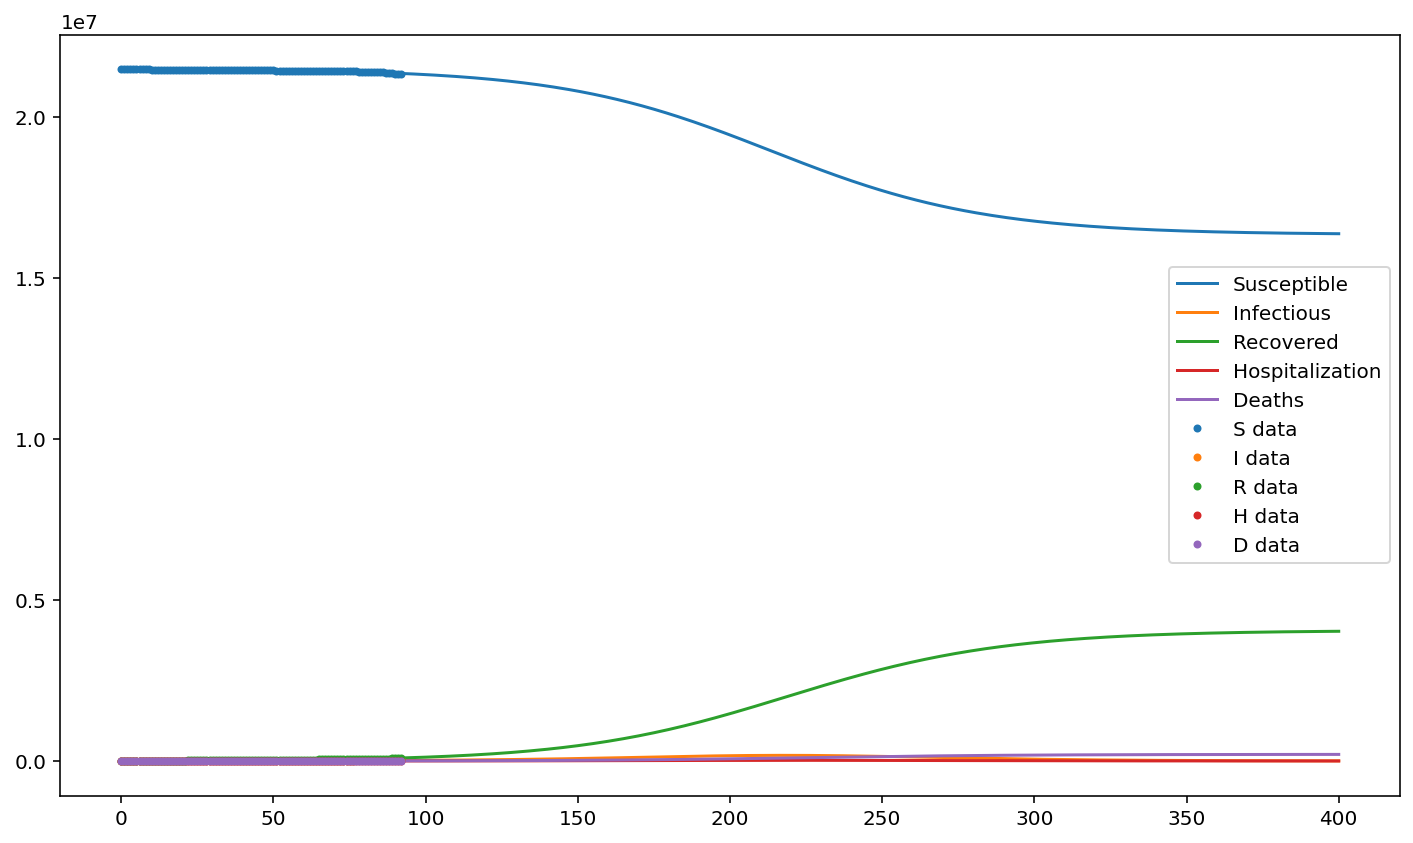

In [348]:
simulated, totalHospitalized = sirhdBasic(S0,I0,R0,H0,D0,xB[0],xB[1]/S0,xB[2],xB[3],xB[4],xB[5],400)

# Plot the simulated data as curves
plt.plot(simulated[0,:], label='Susceptible')
plt.plot(simulated[1,:], label='Infectious')
plt.plot(simulated[2,:], label='Recovered')
plt.plot(simulated[3,:], label='Hospitalization')
plt.plot(simulated[4,:], label='Deaths')

plt.gca().set_prop_cycle(None)

# Plot the simulated data as curves
plt.plot(data[0,:], '.', label='S data')
plt.plot(data[1,:], '.', label='I data')
plt.plot(data[2,:], '.', label='R data')
plt.plot(data[3,:], '.', label='H data')
plt.plot(data[4,:], '.', label='D data')

plt.legend()

This model predicts 4359179.712681692 total people will be hospitalized.


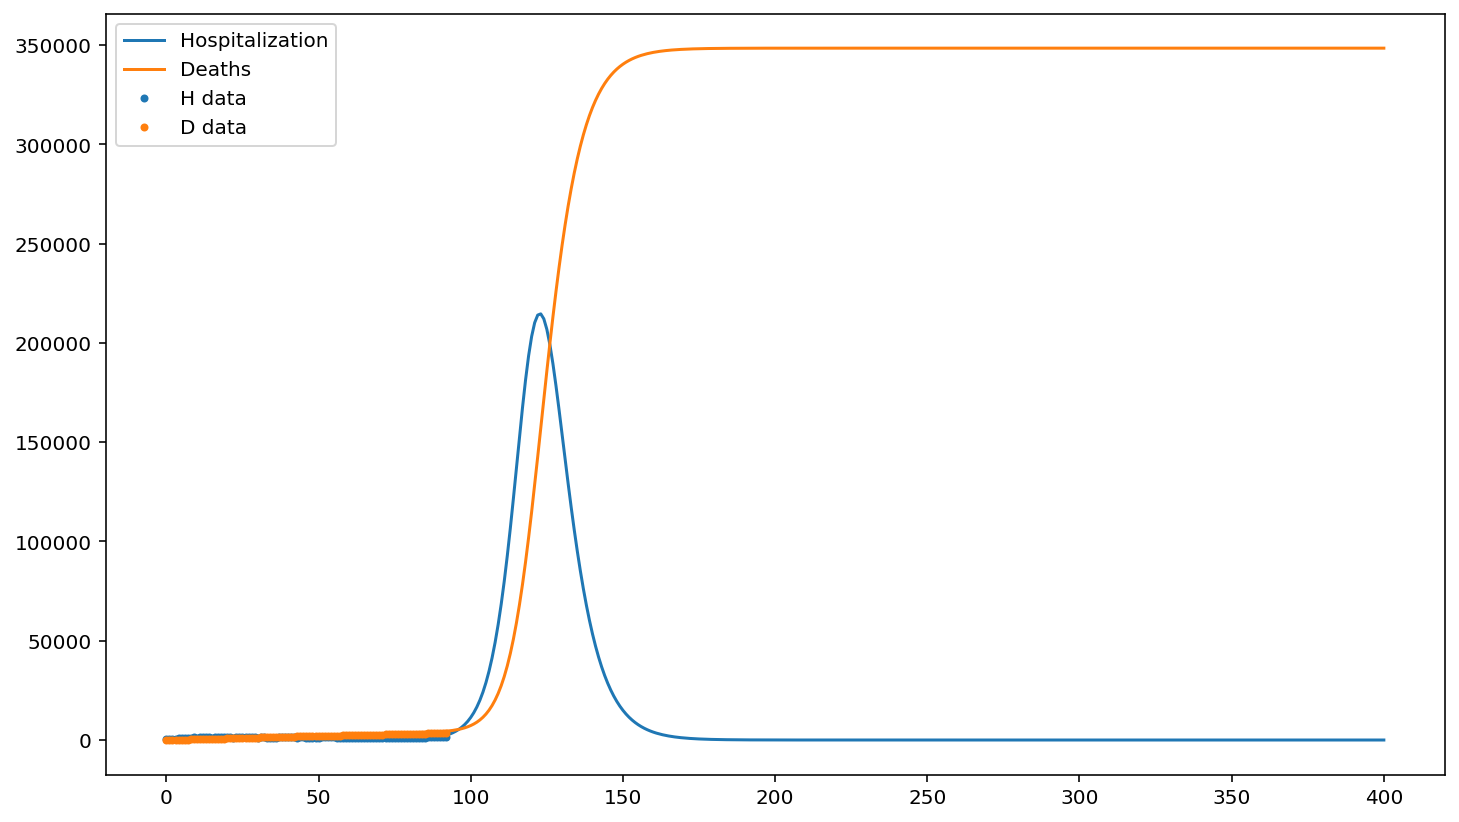

In [355]:
# Plot the simulated data as curves
#plt.plot(simulated[0,:], label='Susceptible')
#plt.plot(simulated[1,:], label='Infectious')
#plt.plot(simulated[2,:], label='Recovered')
plt.plot(simulated[3,:], label='Hospitalization')
plt.plot(simulated[4,:], label='Deaths')

plt.gca().set_prop_cycle(None)

# Plot the simulated data as curves
#plt.plot(data[0,:], '.', label='S data')
#plt.plot(data[1,:], '.', label='I data')
#plt.plot(data[2,:], '.', label='R data')
plt.plot(data[3,:], '.', label='H data')
plt.plot(data[4,:], '.', label='D data')

plt.legend()

print('This model predicts', totalHospitalized, 'total people will be hospitalized.')

In [364]:
## CHOOSE THE OPTIMAL PARAMETERS TO FIT A MODEL TO THE DATA

# Advanced Model
f = lambda x: findError(sirhdAdvancedH(S0,I0,R0,H0,D0,x[0],x[1]/S0,x[2],x[3],x[4],x[5],x[6],x[7],x[8],lastDay)[0], data)
#f = lambda x: findError(sirhdAdvancedH(S0,I0,R0,H0,R0,xB[0],xB[1]/S0,xB[2],x[0],x[1],x[2],x[3],xB[4],xB[5],lastDay)[0], data)

# Run the optimization code (multidimensional gradient descent) to find the best parameters for ths model
# to fit to the data. (This solves for *all* parameters at one time!)

result = optimize.minimize(f, [0.1, 0.2, 0.05, 0.05, 0.1, lastDay/2, 1, 0.05, 0.05],
                          bounds=((0.01,1), (0.01,1), (0.01,1), (0.01,1), (0.01,1), (0,lastDay), (-5,5), (0.01,1), (0.01,1)))
#result = optimize.minimize(f, [0.05, 0.1, lastDay/2, 1],
#                           bounds=((0,1),(0,1),(0,lastDay),(-5,5)))

print(result)

xA = result.x

      fun: 108183.71498289729
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.20497134e+02, -3.07714800e+01,  8.27541953e+03, -2.09429709e+02,
       -5.03219780e+01,  2.12516303e+01,  1.80298231e+00, -2.98579107e+02,
       -7.27658331e+02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1350
      nit: 99
     njev: 135
   status: 0
  success: True
        x: array([8.22688201e-02, 4.04759790e-01, 1.00000000e-02, 2.41906025e-01,
       4.23129840e-02, 7.78829878e+01, 3.77194120e+00, 6.47163304e-02,
       8.80064250e-01])


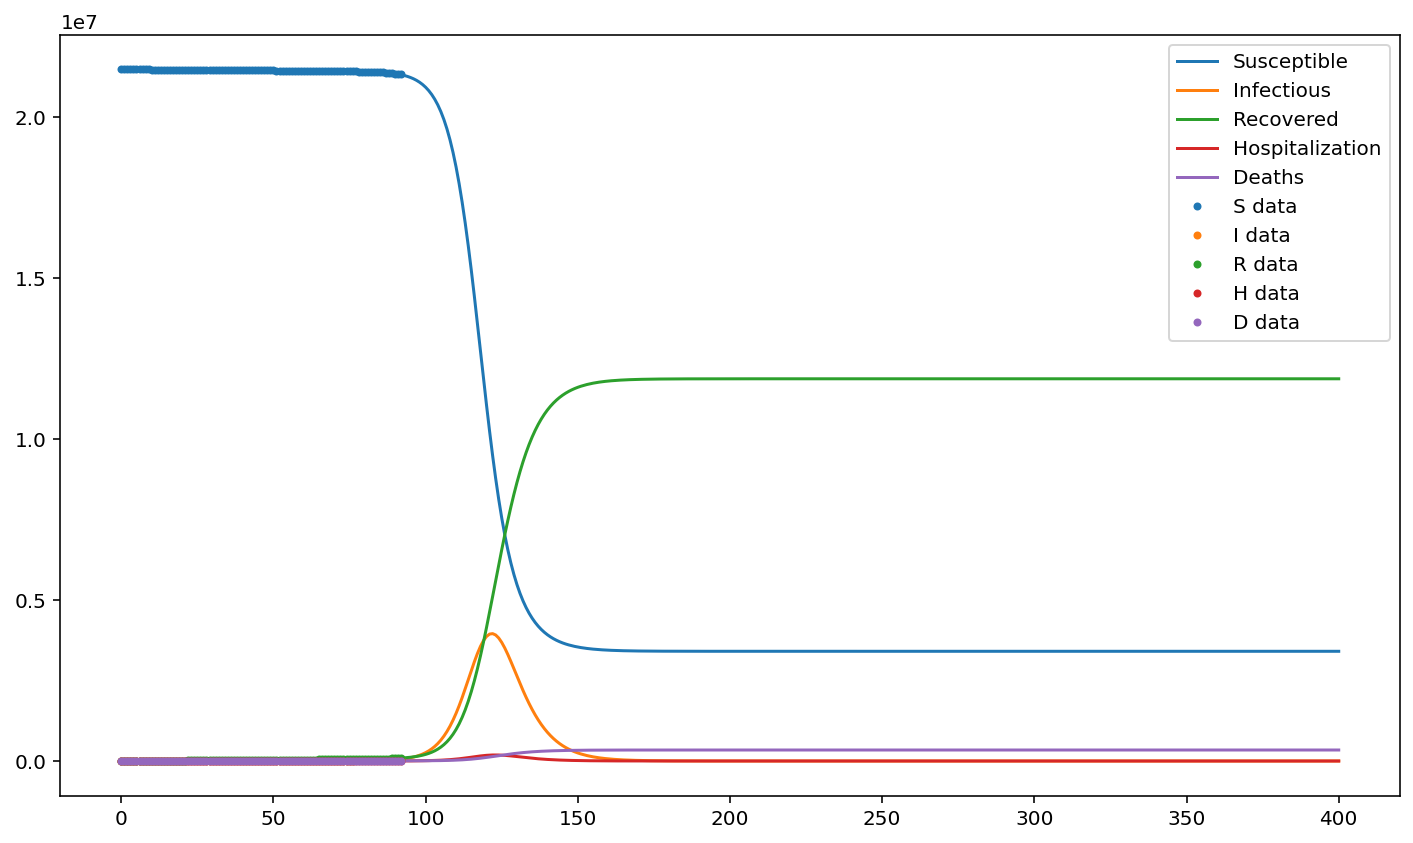

In [365]:
simulated, totalHospitalized = sirhdAdvancedH(S0,I0,R0,H0,D0,xA[0],xA[1]/S0,xA[2],xA[3],xA[4],xA[5],xA[6],xA[7],xA[8],400)
#sirhdAdvancedH(S0,I0,R0,H0,D0,x[0],xB[1]/S0,xB[2],xA[0],xA[1],xA[2],xA[3],xB[4],xB[5],400)

# Plot the simulated data as curves
plt.plot(simulated[0,:], label='Susceptible')
plt.plot(simulated[1,:], label='Infectious')
plt.plot(simulated[2,:], label='Recovered')
plt.plot(simulated[3,:], label='Hospitalization')
plt.plot(simulated[4,:], label='Deaths')

plt.gca().set_prop_cycle(None)

# Plot the simulated data as curves
plt.plot(data[0,:], '.', label='S data')
plt.plot(data[1,:], '.', label='I data')
plt.plot(data[2,:], '.', label='R data')
plt.plot(data[3,:], '.', label='H data')
plt.plot(data[4,:], '.', label='D data')

plt.legend()

This model predicts 4067894.315588744 total people will be hospitalized.


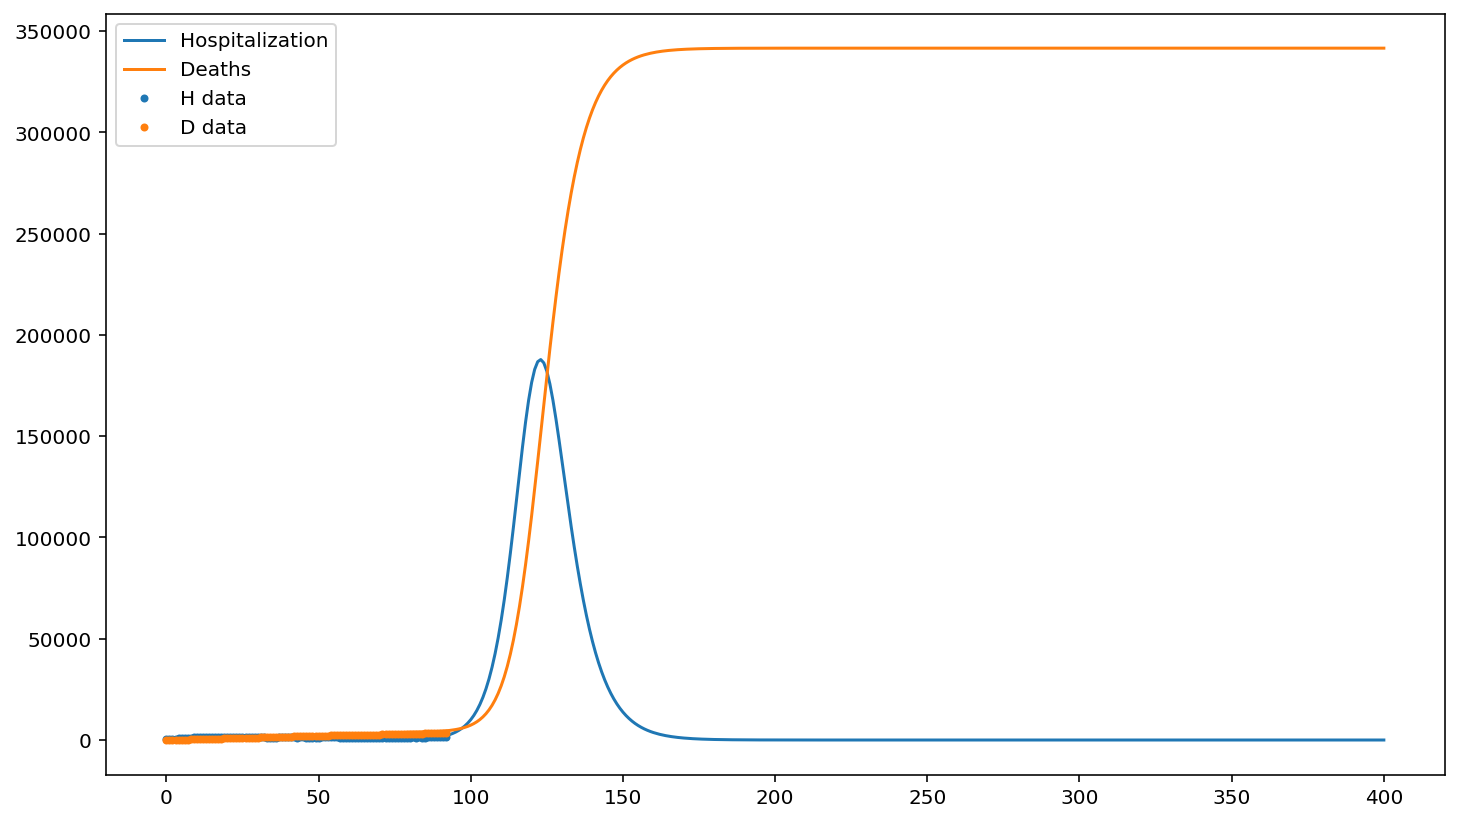

In [366]:
# Plot the simulated data as curves
#plt.plot(simulated[0,:], label='Susceptible')
#plt.plot(simulated[1,:], label='Infectious')
#plt.plot(simulated[2,:], label='Recovered')
plt.plot(simulated[3,:], label='Hospitalization')
plt.plot(simulated[4,:], label='Deaths')

plt.gca().set_prop_cycle(None)

# Plot the simulated data as curves
#plt.plot(data[0,:], '.', label='S data')
#plt.plot(data[1,:], '.', label='I data')
#plt.plot(data[2,:], '.', label='R data')
plt.plot(data[3,:], '.', label='H data')
plt.plot(data[4,:], '.', label='D data')

plt.legend()

print('This model predicts', totalHospitalized, 'total people will be hospitalized.')

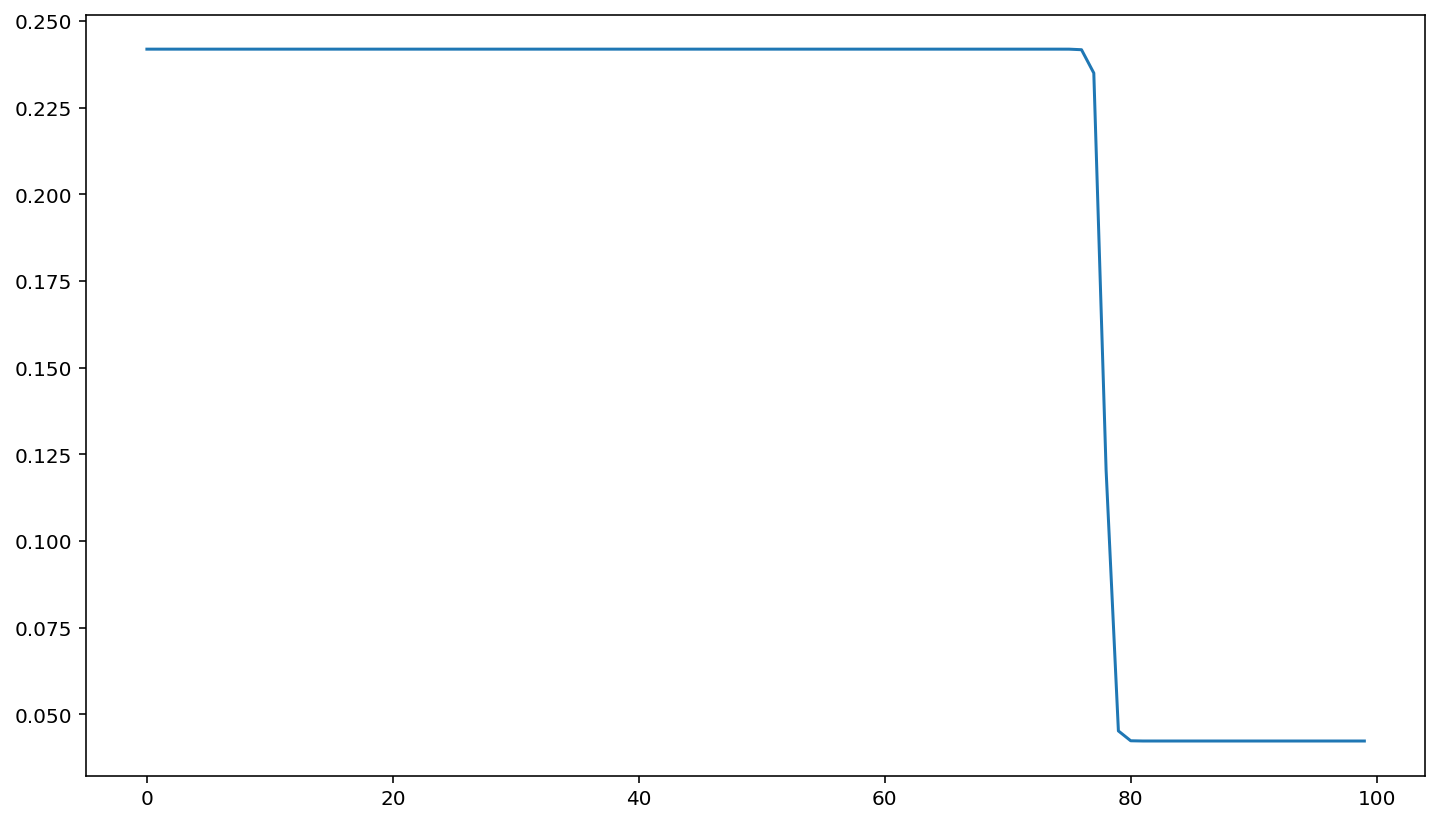

In [367]:
xvals = np.zeros([100,1])
for i in range(100):
    xvals[i] = (xA[4] - xA[3])*sigmoid(xA[6]*(i - xA[5])) + xA[3]

plt.plot(xvals)